In [35]:
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.odr import ODR, Model, RealData

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

from main_code.utils.constants import *
from main_code.utils.CosmoFunc import *
from main_code.utils.functions import bin_data, bin_data_median, bin_data_error_weighting

In [2]:
df = pd.read_csv("../../artifacts/fp_fit/smin_setting_1/fp_fit_method_0/fp_fits.csv", index_col=0)
df["c"] = df["rmean"] - df["a"] * df["smean"] - df["b"] * df["imean"]
a = df["a"].values[0]
b = df["b"].values[0]
c = df["c"].values[0]

df

,a,b,rmean,smean,imean,s1,s2,s3,c
6dFGS,1.419585,-0.868787,0.188641,2.258447,3.211987,0.041763,0.287499,0.147204,-0.226886
SDSS,1.437831,-0.898644,0.155866,2.237594,3.183340,0.045066,0.272557,0.163546,-0.200726
LAMOST,1.458118,-0.918159,-0.043616,2.167199,3.286299,0.049962,0.276993,0.164573,-0.186302
ALL_COMBINED,1.448729,-0.894661,0.140691,2.240512,3.217048,0.045052,0.286057,0.156652,-0.227037


In [15]:
fp_params = df.loc["ALL_COMBINED"]["rmean"]
fp_params

0.1406914873835815

# 1st case: $\bar{r}$ fixed

In [17]:
# Candidates for smean and imean
smean = 2.167199
imean = 3.286299

rmean = c + a * smean + b * imean

print("rmean: ", rmean)
print("smean: ", smean)
print("imean: ", imean)

_ = ("r_fixed", rmean, smean, imean)
print(_)

rmean:  -0.005454662097718277
smean:  2.167199
imean:  3.286299
('r_fixed', -0.005454662097718277, 2.167199, 3.286299)


# 2nd case: $\bar{s}$ fixed

In [18]:
# Candidates for smean and imean
rmean = -0.043616
imean = 3.286299

smean = (rmean - c - b * imean) / a

print("rmean: ", rmean)
print("smean: ", smean)
print("imean: ", imean)

_ = ("s_fixed", rmean, smean, imean)
print(_)

rmean:  -0.043616
smean:  2.1403169682741696
imean:  3.286299
('s_fixed', -0.043616, 2.1403169682741696, 3.286299)


# 3rd case: $\bar{\imath}$ fixed

In [19]:
# Candidates for smean and imean
rmean = -0.043616
smean = 2.167199

imean = (rmean - c - a* smean) / b

print("rmean: ", rmean)
print("smean: ", smean)
print("imean: ", imean)

_ = ("i_fixed", rmean, smean, imean)
print(_)

rmean:  -0.043616
smean:  2.167199
imean:  3.3302238673166817
('i_fixed', -0.043616, 2.167199, 3.3302238673166817)


# Investigate any difference

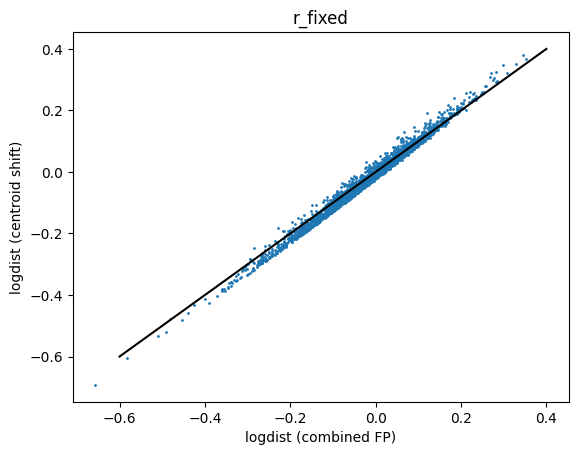

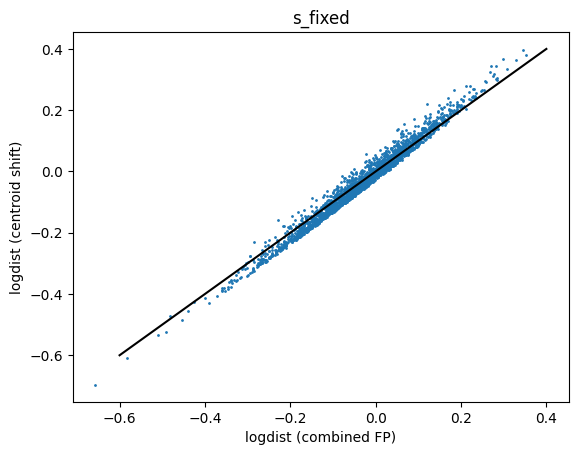

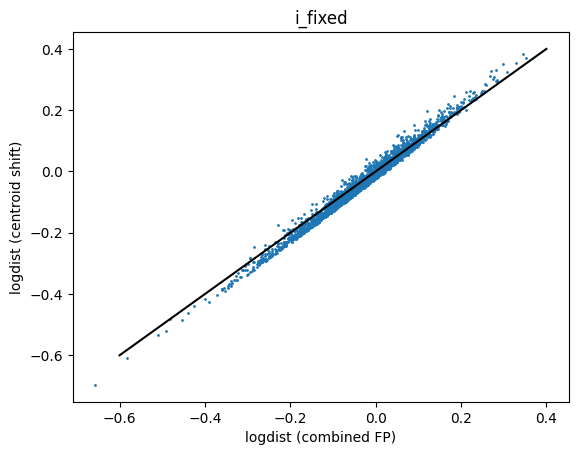

In [36]:
# Load old data
df_old = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/lamost.csv")
df_old["logdist_individual_fp"] = df_old["logdist_lamost"]
df_old["logdist_err_individual_fp"] = df_old["logdist_err_lamost"]
df_old["logdist_combined_fp"] = df_old["logdist_all_combined"]
df_old["logdist_err_combined_fp"] = df_old["logdist_err_all_combined"]
df_old = df_old[[col for col in df_old.columns if col in ["tmass", "logdist_individual_fp", "logdist_err_individual_fp", "logdist_combined_fp", "logdist_err_combined_fp"]]]

# Load new data
df_new = pd.read_csv("./lamost.csv")

# Cross-match
df = df_old.merge(df_new, on="tmass")

# Plots
for label_ in ["r_fixed", "s_fixed", "i_fixed"]:
    plt.figure()
    plt.title(label_)
    plt.scatter(df["logdist_combined_fp"], df[f"logdist_{label_}"], s=1)
    plt.xlabel("logdist (combined FP)")
    plt.ylabel("logdist (centroid shift)")
    plt.plot([-0.6, 0.4], [-0.6, 0.4], c='k')

# PV bias vs redshift (mean)

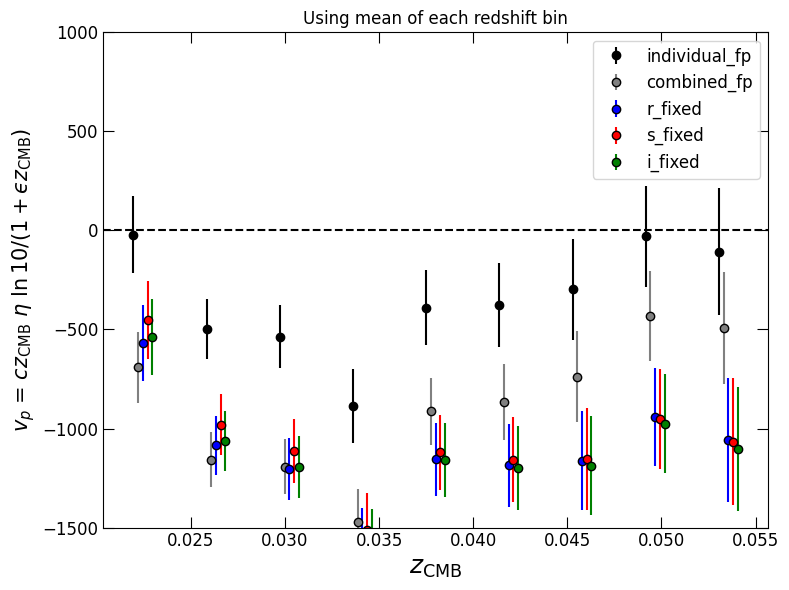

In [47]:
# Load old data
df_old = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/lamost.csv")
df_old["logdist_individual_fp"] = df_old["logdist_lamost"]
df_old["logdist_err_individual_fp"] = df_old["logdist_err_lamost"]
df_old["logdist_combined_fp"] = df_old["logdist_all_combined"]
df_old["logdist_err_combined_fp"] = df_old["logdist_err_all_combined"]
df_old = df_old[[col for col in df_old.columns if col in ["tmass", "logdist_individual_fp", "logdist_err_individual_fp", "logdist_combined_fp", "logdist_err_combined_fp"]]]

# Load new data
df_new = pd.read_csv("./lamost.csv")

# Cross-match
df = df_old.merge(df_new, on="tmass")


epsilon = 0.75
z_col = "z_dist_est"

colors = ["black", "grey", "blue", "red", "green"]

fig, ax = plt.subplots(figsize=(8, 6))

# Load data
for i, method in enumerate(["individual_fp", "combined_fp", "r_fixed", "s_fixed", "i_fixed"]):
    df["pv"] = LightSpeed * df[z_col] * df[f"logdist_{method}"] * np.log(10) / (1 + epsilon * df[z_col])
    df["pv_err"] = LightSpeed * df[z_col] * df[f"logdist_err_{method}"] * np.log(10) / (1 + epsilon * df[z_col])

    # Get error-weighted average in bins
    x = df[z_col].to_numpy()
    y = df[f"pv"].to_numpy()
    yerr = df[f"pv_err"].to_numpy()

    # Mean
    x_bin, y_ew_bin, y_ew_bin_err, y_ew_bin_stderr = bin_data(x, y, 0.02, 0.055, 10)

    # Plot
    ax.errorbar(x_bin + i * 0.00025, y_ew_bin, yerr=y_ew_bin_stderr, fmt="o", mec='k', mfc=colors[i], ecolor=colors[i], alpha=1.0, label=method)

# ax.legend(loc="lower right", fontsize=14)
ax.axhline(y=0, c='k', ls='--')
ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
ax.set_ylabel(r"$v_p$ = $cz_\mathrm{CMB}\ \eta\ \ln 10$/($1+ϵ z_\mathrm{CMB}$)", fontsize=15)
ax.set_title(f"Using mean of each redshift bin")

ax.set_ylim(-1500, 1000)
ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
ax.tick_params(axis='both', which='both', labelsize=12, direction="in")
ax.tick_params(axis='both', which='major', length=8)
ax.tick_params(axis='both', which='minor', length=4)

ax.legend(loc="upper right", fontsize=12)

fig.tight_layout()
fig.savefig(f"./mean.png", bbox_inches='tight', dpi=300)

# PV bias vs redshift (error-weighted mean)

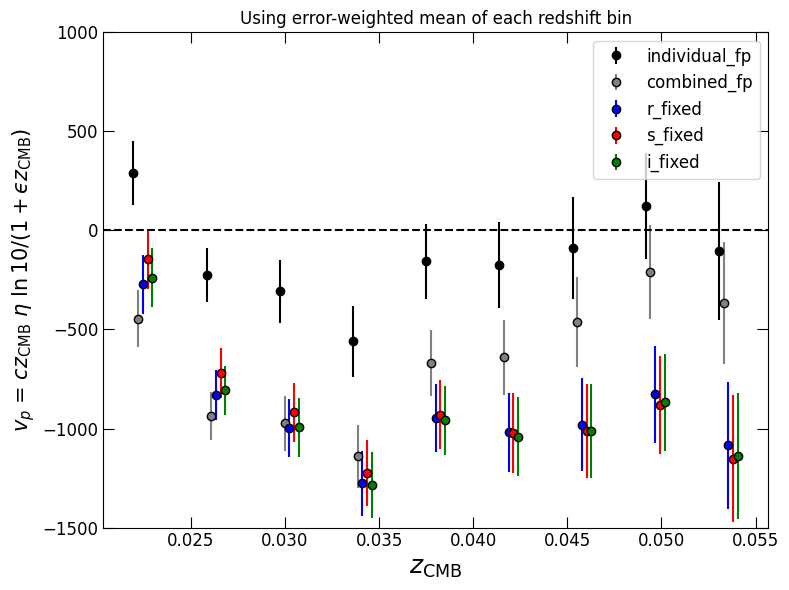

In [48]:
# Load old data
df_old = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/lamost.csv")
df_old["logdist_individual_fp"] = df_old["logdist_lamost"]
df_old["logdist_err_individual_fp"] = df_old["logdist_err_lamost"]
df_old["logdist_combined_fp"] = df_old["logdist_all_combined"]
df_old["logdist_err_combined_fp"] = df_old["logdist_err_all_combined"]
df_old = df_old[[col for col in df_old.columns if col in ["tmass", "logdist_individual_fp", "logdist_err_individual_fp", "logdist_combined_fp", "logdist_err_combined_fp"]]]

# Load new data
df_new = pd.read_csv("./lamost.csv")

# Cross-match
df = df_old.merge(df_new, on="tmass")


epsilon = 0.75
z_col = "z_dist_est"

colors = ["black", "grey", "blue", "red", "green"]

fig, ax = plt.subplots(figsize=(8, 6))

# Load data
for i, method in enumerate(["individual_fp", "combined_fp", "r_fixed", "s_fixed", "i_fixed"]):
    df["pv"] = LightSpeed * df[z_col] * df[f"logdist_{method}"] * np.log(10) / (1 + epsilon * df[z_col])
    df["pv_err"] = LightSpeed * df[z_col] * df[f"logdist_err_{method}"] * np.log(10) / (1 + epsilon * df[z_col])

    # Get error-weighted average in bins
    x = df[z_col].to_numpy()
    y = df[f"pv"].to_numpy()
    yerr = df[f"pv_err"].to_numpy()

    # Mean
    x_bin, y_ew_bin, y_ew_bin_err, y_ew_bin_stderr = bin_data_error_weighting(x, y, yerr, 0.02, 0.055, 10)

    # Plot
    ax.errorbar(x_bin + i * 0.00025, y_ew_bin, yerr=y_ew_bin_stderr, fmt="o", mec='k', mfc=colors[i], ecolor=colors[i], alpha=1.0, label=method)

# ax.legend(loc="lower right", fontsize=14)
ax.axhline(y=0, c='k', ls='--')
ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
ax.set_ylabel(r"$v_p$ = $cz_\mathrm{CMB}\ \eta\ \ln 10$/($1+ϵ z_\mathrm{CMB}$)", fontsize=15)
ax.set_title(f"Using error-weighted mean of each redshift bin")

ax.set_ylim(-1500, 1000)
ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
ax.tick_params(axis='both', which='both', labelsize=12, direction="in")
ax.tick_params(axis='both', which='major', length=8)
ax.tick_params(axis='both', which='minor', length=4)

ax.legend(loc="upper right", fontsize=12)

fig.tight_layout()
fig.savefig(f"./ew_mean_fp_bias.png", bbox_inches='tight', dpi=300)

# PV bias vs redshift (median)

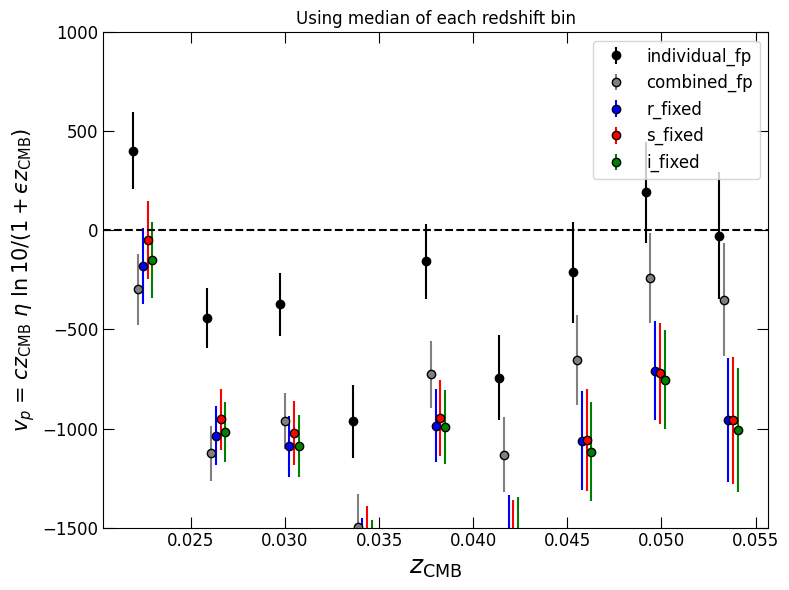

In [49]:
# Load old data
df_old = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/lamost.csv")
df_old["logdist_individual_fp"] = df_old["logdist_lamost"]
df_old["logdist_err_individual_fp"] = df_old["logdist_err_lamost"]
df_old["logdist_combined_fp"] = df_old["logdist_all_combined"]
df_old["logdist_err_combined_fp"] = df_old["logdist_err_all_combined"]
df_old = df_old[[col for col in df_old.columns if col in ["tmass", "logdist_individual_fp", "logdist_err_individual_fp", "logdist_combined_fp", "logdist_err_combined_fp"]]]

# Load new data
df_new = pd.read_csv("./lamost.csv")

# Cross-match
df = df_old.merge(df_new, on="tmass")


epsilon = 0.75
z_col = "z_dist_est"

colors = ["black", "grey", "blue", "red", "green"]

fig, ax = plt.subplots(figsize=(8, 6))

# Load data
for i, method in enumerate(["individual_fp", "combined_fp", "r_fixed", "s_fixed", "i_fixed"]):
    df["pv"] = LightSpeed * df[z_col] * df[f"logdist_{method}"] * np.log(10) / (1 + epsilon * df[z_col])
    df["pv_err"] = LightSpeed * df[z_col] * df[f"logdist_err_{method}"] * np.log(10) / (1 + epsilon * df[z_col])

    # Get error-weighted average in bins
    x = df[z_col].to_numpy()
    y = df[f"pv"].to_numpy()
    yerr = df[f"pv_err"].to_numpy()

    # Mean
    x_bin, y_ew_bin, y_ew_bin_err, y_ew_bin_stderr = bin_data_median(x, y, 0.02, 0.055, 10)

    # Plot
    ax.errorbar(x_bin + i * 0.00025, y_ew_bin, yerr=y_ew_bin_stderr, fmt="o", mec='k', mfc=colors[i], ecolor=colors[i], alpha=1.0, label=method)

# ax.legend(loc="lower right", fontsize=14)
ax.axhline(y=0, c='k', ls='--')
ax.set_xlabel(r"$z_\mathrm{CMB}$", fontsize=18)
ax.set_ylabel(r"$v_p$ = $cz_\mathrm{CMB}\ \eta\ \ln 10$/($1+ϵ z_\mathrm{CMB}$)", fontsize=15)
ax.set_title(f"Using median of each redshift bin")

ax.set_ylim(-1500, 1000)
ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
ax.tick_params(axis='both', which='both', labelsize=12, direction="in")
ax.tick_params(axis='both', which='major', length=8)
ax.tick_params(axis='both', which='minor', length=4)

ax.legend(loc="upper right", fontsize=12)

fig.tight_layout()
fig.savefig(f"./median.png", bbox_inches='tight', dpi=300)